# Oil wells Spatial Autocorrelation Exercise

In [ ]:
We want to begin understanding the spatial correlation of active oil wells across the Los Angeles county. Once we have established the spatial autocorrelation, we will begin delving into neighborhood-level analysis using the Oil wells and the CalEnviro score datasets 

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# To allow us to conduct block-level analysis, we will import block level geopson
gdf_bg = gpd.read_file('Data_DM/ACS_Block_5year_race.csv')

In [3]:
# what does our data look like?
gdf_bg.columns

Index(['Geo_FIPS', 'Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP',
       'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_COUSUB', 'Geo_PLACE', 'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT',
       'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITS', 'Geo_ANRC',
       'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI',
       'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_CDCURR',
       'Geo_SLDU', 'Geo_SLDL', 'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD',
       'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_PUMA5',
       'Geo_NAME', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PLACESE', 'SE_A00001_001',
       'SE_B04001_001', 'SE_B04001_002', 'SE_B04001_003', 'SE_B04001_004',
       'SE_B04001_005', 'SE_B04001_006', 'SE_B04001_007', 'SE_B04001_008',
       'SE_B04001_009', 'SE_B04001_010', 'SE_A03001B_001', 'SE_A03001B_002',
       'SE_A03001B_003', 'SE_A03001B_004', 'SE_A03001B_005', 'SE_A03001B_006',
       'SE_A03001B_007', '

In [4]:
# List of unnecessary columns to be dropped
columns_to_drop1 = ['Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP',
       'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_COUSUB', 'Geo_PLACE','Geo_TRACT','Geo_CONCIT',
       'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITS', 'Geo_ANRC',
       'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI',
       'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_CDCURR',
       'Geo_SLDU', 'Geo_SLDL', 'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD',
       'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_PUMA5',
       'Geo_NAME', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PLACESE']

# Drop columns using the .drop() method
gdf_bg.drop(columns=columns_to_drop1, inplace=True)

In [5]:
# Assign new names to existing columns using the ACS data dictionary 
column_mapping = {
    'SE_A00001_001': 'Total_Population',
    'SE_B04001_001': 'Total_Population:',
    'SE_B04001_002': 'Not_Hispanic_or_Latino',
    'SE_B04001_003': 'White_Alone',
    'SE_B04001_004': 'Black_or_African_American_Alone',
    'SE_B04001_005': 'American_Indian_and_Alaska Native_Alone',
    'SE_B04001_006': 'Asian_Alone',
    'SE_B04001_007': 'Native_Hawaiian_and Other_Pacific_Islander_Alone',
    'SE_B04001_008': 'Some_Other_Race_Alone',
    'SE_B04001_009': 'Two_or_More_Races',
    'SE_B04001_010': 'Hispanic_or_Latino',
    'SE_A03001B_001': 'Renter-Occupied_Housing_Units:',
    'SE_A03001B_002': 'White_Alone_Householder',
    'SE_A03001B_003': 'Black_or_African_American_Alone_Householder',
    'SE_A03001B_004': 'American_Indian_and_Alaska_Native_Alone_Householder',
    'SE_A03001B_005': 'Asian_Alone_Householder',
    'SE_A03001B_006': 'Native_Hawaiian_and_Other Pacific_Islander_Alone_Householder',
    'SE_A03001B_007': 'Some_Other_Race_Alone_Householder',
    'SE_A03001B_008': 'Two_or_More_Races_Householder',
    'SE_A03001B_009': 'White_Alone_Not_Hispanic_or_Latino Householder',
    'SE_A03001B_010': 'Hispanic_or_Latino_Householder',
    'SE_B10060_001': 'Owner_Occupied_Housing_Units:',
    'SE_B10060_002': 'White_Alone_Not_Hispanic_or_Latino_Homeowners',
    'SE_B10060_003': 'Non-White_Homeowners'
}
# Rename columns using the .rename() method
gdf_bg.rename(columns=column_mapping, inplace=True)

# Display the DataFrame with updated column names
print(gdf_bg)

          Geo_FIPS Geo_BLKGRP Total_Population Total_Population:  \
0     060371011101          1             1415              1415   
1     060371011102          2             1826              1826   
2     060371011103          3              773               773   
3     060371011221          1             2754              2754   
4     060371011222          2             1410              1410   
...            ...        ...              ...               ...   
6586  060379800381          1                0                 0   
6587  060379800391          1                0                 0   
6588  060379901000          0                0                 0   
6589  060379902000          0                0                 0   
6590  060379903000          0                0                 0   

     Not_Hispanic_or_Latino White_Alone Black_or_African_American_Alone  \
0                      1053         788                              91   
1                      1309      

In [6]:
## Import, Clean, and Use Data

Now, we will import the Census Tracts file and merge it with the block group dataset to attain geometry information

In [9]:
# import the tracts dataset and read as dataframe
tracts = gpd.read_file('Data_DM/Census_Tracts_2020_DM.geojson')
# retain the most important columns 
tracts = tracts[['CT20','geometry']]

In [10]:
# Create a Geo_FIPS column to allow mergeing
tracts['Geo_FIPS'] = '06'+ '037' + tracts['CT20']
tracts.Geo_FIPS = tracts.Geo_FIPS.astype('int')

In [11]:
gdf_bg.Geo_FIPS = tracts.Geo_FIPS.astype('int')

In [12]:
# Merge DataFrames on the 'Geo_FIPS' column
bg_geo = pd.merge(gdf_bg, tracts, on='Geo_FIPS', how='left')
bg_geo.head(10)
print(bg_geo[['geometry_y']])

                                             geometry_y
0     POLYGON ((-118.28491 34.25948, -118.28492 34.2...
1     POLYGON ((-118.29015 34.27417, -118.29015 34.2...
2     POLYGON ((-118.28100 34.25592, -118.28198 34.2...
3     POLYGON ((-118.28735 34.25591, -118.28863 34.2...
4     POLYGON ((-118.28594 34.25405, -118.28594 34.2...
...                                                 ...
6586                                               None
6587                                               None
6588                                               None
6589                                               None
6590                                               None

[6591 rows x 1 columns]


In [13]:
# Extract x and y coordinates from the 'geometry_y' column for MultiPolygon
def extract_coordinates(geom, coordinate_type='xy'):
    if geom is None or geom.is_empty:
        return None
    if geom.geom_type == 'Polygon':
        exterior_coords = list(geom.exterior.coords)
        return list(zip(*exterior_coords)) if coordinate_type == 'xy' else exterior_coords

# Extract x and y coordinates for Polygon geometries
bg_geo[['Longitude', 'Latitude']] = bg_geo['geometry_y'].apply(lambda geom: pd.Series(extract_coordinates(geom), index=['Longitude', 'Latitude']))

# Drop rows with empty geometry in 'geometry_y' column
bg_geo = bg_geo.dropna(subset=['geometry_y'])

# Print the columns of interest to verify 
print(bg_geo[['Geo_FIPS','Latitude', 'Longitude']])

          Geo_FIPS                                           Latitude  \
0     6.037101e+09  (34.259483876604655, 34.26178187636133, 34.262...   
1     6.037101e+09  (34.2741708780824, 34.274394877414906, 34.2760...   
2     6.037101e+09  (34.2559208764382, 34.2559028759478, 34.255901...   
3     6.037101e+09  (34.25590887623749, 34.25591687571608, 34.2559...   
4     6.037101e+09  (34.254049875504755, 34.254670875677355, 34.25...   
...            ...                                                ...   
2490  6.037980e+09  (34.044692870138846, 34.04482187003807, 34.045...   
2491  6.037980e+09  (34.057245866678976, 34.05724886669209, 34.057...   
2492  6.037980e+09  (33.80773082663446, 33.80777882680485, 33.8077...   
2493  6.037980e+09  (34.01538584542292, 34.015626845375714, 34.015...   
2494  6.037980e+09  (34.142181860016066, 34.142184860115215, 34.14...   

                                              Longitude  
0     (-118.2849112110134, -118.28492221135741, -118...  
1     (

In [14]:
bg_geo = bg_geo.set_geometry('geometry_y')
bg_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
Oil = gpd.read_file('Data_DM/Oil_Wells.csv')

In [16]:
# convert pandas dataframe to geodataframe
Oil = gpd.GeoDataFrame(Oil, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(Oil.Longitude, Oil.Latitude))

In [17]:
Oil.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# get the layers into a web mercator projection
# reproject to web mercator
Oil = Oil.to_crs(epsg=3857)

In [19]:
# convert lat/lon to floats
Oil.Longitude = Oil.Longitude.astype('float')
Oil.Latitude = Oil.Latitude.astype('float')

In [ ]:
# Find points with longitude and latitude equal to 0 remove the (0,0) conundrum 
filtered_points = Oil[Oil['Longitude'] == 0.0][Oil['Latitude']== 0.0]
# Remove the filtered subset from the original dataset
Oil = Oil.drop(filtered_points.index)

In [ ]:
Let's repeat the mapping but first, we will specify the bounds, project the block gdf to web mercator, and then get to plotting the block group and oil wells data together. 

In [23]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = Oil.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13214343.460308531
-13115437.985170051
3992577.6798288384
4093992.4855941865


In [24]:
# get the layers into a web mercator projection
# reproject to web mercator
bg_geo = bg_geo.to_crs(epsg=3857)

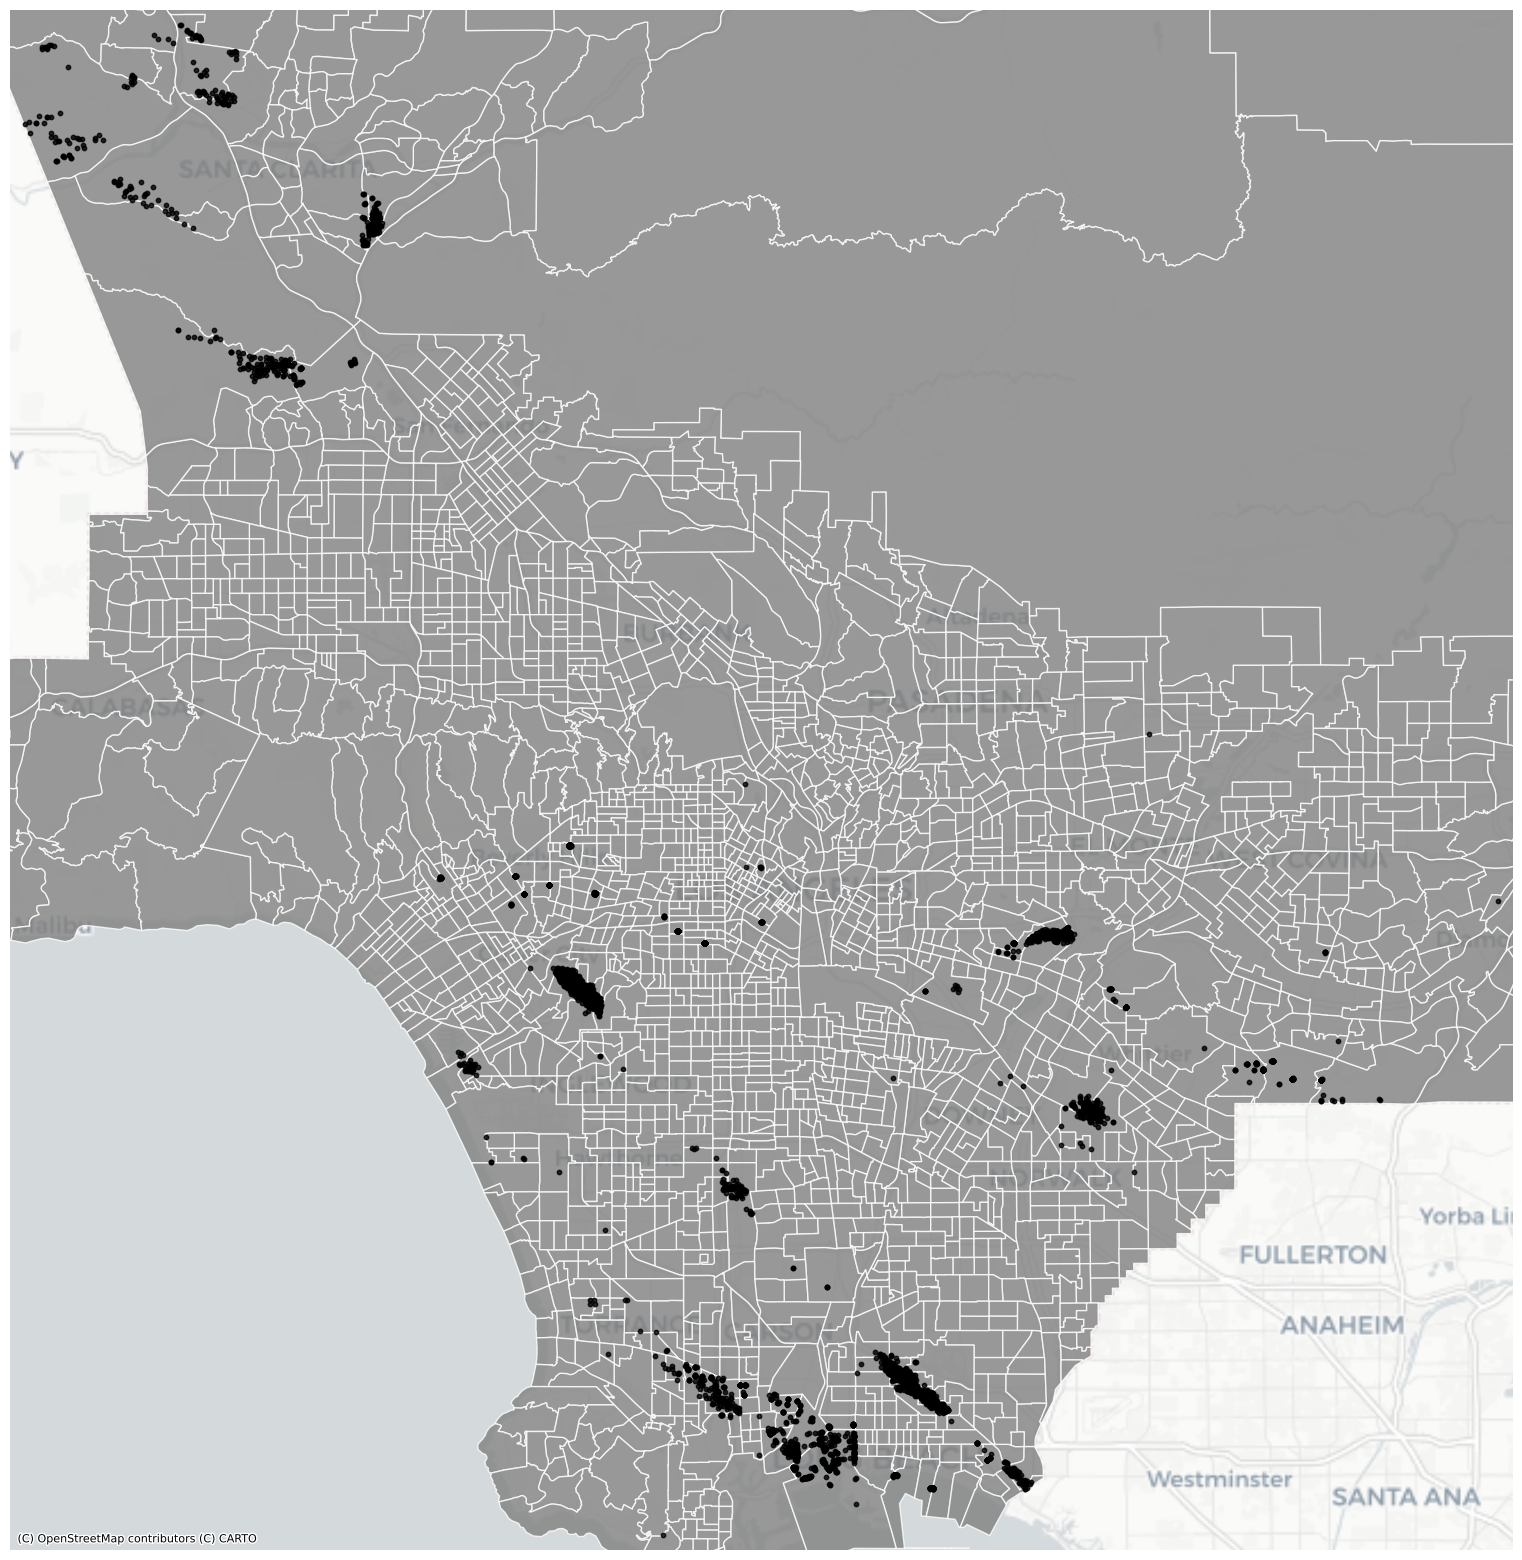

In [25]:
# visualize and test the block segmentation w/ base graphic
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
bg_geo.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.8)

# Oil
Oil.plot(ax=ax, # this also puts it in the same ax plot
        color='Black',
        markersize=10,
        alpha=0.8)

# set the x and y limits for the bounding box coordinates to 
ax.set_xlim(minx - 1000, maxx + 1000) # margins to total bounds 
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
## Joint Analysis: Block group and Oil well data analysis

In [26]:
# first check number of the dataset with primary variable of analysis, the LA county oil well data
Oil.shape

(3858, 27)

In [27]:
# Make sure GeoDataFrames are both projected to Web Mercator
bg_geo = bg_geo.to_crs('EPSG:3857')
Oil = Oil.to_crs('EPSG:3857')

In [28]:
Merged_gdf = gpd.sjoin(bg_geo,Oil, how='right')
Merged_gdf.head(10)

,index_left,Geo_FIPS,Geo_BLKGRP,Total_Population,Total_Population:,Not_Hispanic_or_Latino,White_Alone,Black_or_African_American_Alone,American_Indian_and_Alaska Native_Alone,Asian_Alone,...,Longitude_right,GISSourceC,LeaseName,Directiona,GISSymbol,LatestUpdate,DataSource,TOOLTIP,NLA_URL,geometry
0,2279,6.037703e+09,2,2407,2407,2138,1483,43,0,526,...,-118.365867,gps,BC,N,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700200,POINT (-13176428.042 4028566.912)
1,2493,6.037980e+09,2,701,701,575,225,142,0,174,...,-118.383609,gps,TVIC,N,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700254,POINT (-13178403.072 4030257.263)
2,757,6.037222e+09,3,1687,1687,986,713,18,12,235,...,-118.296502,gps,Jefferson,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700302,POINT (-13168706.365 4032334.558)
3,727,6.037219e+09,1,1263,1263,948,637,46,0,256,...,-118.320936,gps,Fourth Avenue,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700308,POINT (-13171426.346 4034120.579)
4,746,6.037221e+09,1,1322,1322,1168,925,0,0,243,...,-118.312868,gps,Murphy,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700383,POINT (-13170528.220 4033134.310)
5,762,6.037224e+09,2,1692,1692,783,407,58,0,268,...,-118.262157,gps,L.A. Unit,Y,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Nasco Petroleum, L.L.C.\nAPI No: 037...",navigatela/reports/oil_wells.cfm?pk=03700458,POINT (-13164883.097 4033734.900)
6,762,6.037224e+09,2,1692,1692,783,407,58,0,268,...,-118.262034,gps,L.A. Unit Venice FW,Y,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Nasco Petroleum, L.L.C.\nAPI No: 037...",navigatela/reports/oil_wells.cfm?pk=03700467,POINT (-13164869.405 4033724.557)
7,2488,6.037980e+09,2,934,934,859,726,0,0,133,...,-118.230520,opr,,N,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Tidelands Oil Production Co.\nAPI No...,navigatela/reports/oil_wells.cfm?pk=03700621,POINT (-13161361.283 3997110.645)
8,1641,6.037530e+09,3,614,614,530,292,104,0,64,...,-118.109788,gps,Mgs,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Southern California Gas Company\nAPI...,navigatela/reports/oil_wells.cfm?pk=03700631,POINT (-13147921.458 4032361.153)
9,2472,6.037980e+09,1,1020,1020,713,501,48,0,164,...,-118.231574,gps,NWU,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Warren E&P, Inc.\nAPI No: 03701280",navigatela/reports/oil_wells.cfm?pk=03701280,POINT (-13161478.613 4000273.897)


In [29]:
Merged_gdf.shape

(3858, 58)

In [ ]:
Merged_gdf shows the number of oil wells for each FIPS code. We are now going to create a new dataframe that shows oil wells by block group

In [30]:
Oil_by_bg = Merged_gdf.Geo_FIPS.value_counts().rename_axis('Geo_FIPS').reset_index(name='oilwell_count')
Oil_by_bg

,Geo_FIPS,oilwell_count
0,6.037980e+09,561
1,6.037980e+09,278
2,6.037295e+09,194
3,6.037530e+09,166
4,6.037980e+09,150
...,...,...
118,6.037651e+09,1
119,6.037551e+09,1
120,6.037208e+09,1
121,6.037291e+09,1


In [ ]:
We will now take this column back to the block geodataframe (bg_geo) and continue analysis

In [31]:
# join the summary table back to the block group gdf
bg_geo=bg_geo.merge(Oil_by_bg,on='Geo_FIPS')
bg_geo.sample(10)

,Geo_FIPS,Geo_BLKGRP,Total_Population,Total_Population:,Not_Hispanic_or_Latino,White_Alone,Black_or_African_American_Alone,American_Indian_and_Alaska Native_Alone,Asian_Alone,Native_Hawaiian_and Other_Pacific_Islander_Alone,...,Hispanic_or_Latino_Householder,Owner_Occupied_Housing_Units:,White_Alone_Not_Hispanic_or_Latino_Homeowners,Non-White_Homeowners,geometry_x,CT20,geometry_y,Longitude,Latitude,oilwell_count
16,6.037291e+09,2,1853,1853,1535,1227,14,0,197,0,...,52,345,222,123,None,291120,"POLYGON ((-13167172.180 4017585.705, -13167375...","(-118.28272018296933, -118.28454318353727, -11...","(33.91642683875789, 33.91642683878015, 33.9164...",3
65,6.037573e+09,2,845,845,467,0,467,0,0,0,...,144,0,0,0,None,573402,"POLYGON ((-13154008.536 4003550.541, -13154064...","(-118.1644691543904, -118.1649701550205, -118....","(33.81173483397165, 33.811723833592175, 33.811...",138
76,6.037578e+09,2,3228,3228,847,57,775,0,15,0,...,446,57,0,57,None,577900,"POLYGON ((-13158098.304 4005661.178, -13158144...","(-118.20120816185216, -118.2016231622858, -118...","(33.82748683314277, 33.82814183357054, 33.8288...",10
84,6.037651e+09,1,635,635,635,595,0,0,40,0,...,0,210,203,7,None,650603,"POLYGON ((-13177209.526 4008485.928, -13177231...","(-118.37288719253262, -118.37308019240179, -11...","(33.84856382607966, 33.84856482603527, 33.8485...",4
64,6.037573e+09,1,2576,2576,1653,192,1427,19,15,0,...,324,22,0,22,None,573401,"POLYGON ((-13155081.545 4004513.357, -13155086...","(-118.17410815659258, -118.17415615673231, -11...","(33.81892083412102, 33.818920834133785, 33.818...",54
15,6.037291e+09,1,1825,1825,1306,848,91,12,297,0,...,190,304,186,118,None,291110,"POLYGON ((-13167157.709 4018564.594, -13167165...","(-118.28259018363791, -118.28266218364779, -11...","(33.92372383916804, 33.92372283920229, 33.9237...",1
61,6.037572e+09,1,1617,1617,997,0,931,0,0,0,...,203,85,0,85,None,572001,"POLYGON ((-13153992.172 4005704.060, -13154027...","(-118.16432215588438, -118.16464215573392, -11...","(33.827806835633254, 33.827806835865246, 33.82...",3
8,6.037222e+09,3,1687,1687,986,713,18,12,235,0,...,183,197,125,72,None,222100,"POLYGON ((-13168640.597 4032449.648, -13168640...","(-118.29591119364007, -118.29591019445176, -11...","(34.027160849863265, 34.02731985066579, 34.028...",29
43,6.037504e+09,2,881,881,551,280,126,0,100,0,...,52,170,70,100,None,504200,"POLYGON ((-13140877.065 4020991.990, -13140876...","(-118.04650714513964, -118.04650114476011, -11...","(33.94181585469831, 33.94247785471515, 33.9431...",120
107,6.037920e+09,1,825,825,749,485,57,0,150,0,...,55,265,134,131,None,920326,"POLYGON ((-13210966.616 4083835.340, -13210975...","(-118.67613228938643, -118.67621028935113, -11...","(34.40886287038097, 34.40900587053421, 34.4088...",7


In [32]:
# We'll now divide the new column variable by total population; examine Total_Population 
bg_geo.Total_Population = bg_geo.Total_Population.astype('int')
median_value = bg_geo['Total_Population'].median()
median_value

1322.0

In [ ]:
# Note: Oil well count per 1000 metric is fitting as the median population is 1,322 people)

In [33]:
bg_geo['oilwells_per_1000'] = bg_geo['oilwell_count']/bg_geo['Total_Population']*1000

In [34]:
bg_geo.sort_values(by="oilwells_per_1000").tail()

,Geo_FIPS,Geo_BLKGRP,Total_Population,Total_Population:,Not_Hispanic_or_Latino,White_Alone,Black_or_African_American_Alone,American_Indian_and_Alaska Native_Alone,Asian_Alone,Native_Hawaiian_and Other_Pacific_Islander_Alone,...,Owner_Occupied_Housing_Units:,White_Alone_Not_Hispanic_or_Latino_Homeowners,Non-White_Homeowners,geometry_x,CT20,geometry_y,Longitude,Latitude,oilwell_count,oilwells_per_1000
65,6.037573e+09,2,845,845,467,0,467,0,0,0,...,0,0,0,None,573402,"POLYGON ((-13154008.536 4003550.541, -13154064...","(-118.1644691543904, -118.1649701550205, -118....","(33.81173483397165, 33.811723833592175, 33.811...",138,163.313609
97,6.037703e+09,2,674,674,634,506,0,0,103,0,...,0,0,0,None,703100,"POLYGON ((-13174251.545 4028404.959, -13174282...","(-118.34631519943483, -118.34659019950156, -11...","(33.99704284426889, 33.99736484398744, 33.9975...",140,207.715134
98,6.037920e+09,5,695,695,516,428,31,0,39,0,...,103,92,11,None,920031,"POLYGON ((-13191452.640 4084362.115, -13191466...","(-118.50083525991109, -118.50096125980039, -11...","(34.41276688113343, 34.41273888102965, 34.4127...",147,211.510791
120,6.037980e+09,2,934,934,859,726,0,0,133,0,...,342,297,45,None,980033,"POLYGON ((-13158941.660 3999659.369, -13159105...","(-118.20878415909623, -118.2102521602642, -118...","(33.782686827678916, 33.78270282837878, 33.782...",278,297.644540
122,6.037980e+09,2,701,701,575,225,142,0,174,0,...,0,0,0,None,980038,"POLYGON ((-13176525.692 4030868.156, -13176524...","(-118.36674420475008, -118.36673120488875, -11...","(34.01538584542292, 34.015626845375714, 34.015...",561,800.285307


In [ ]:
I am interested in seeing the initial oil well counts for every 1000 residents. We can use a regular chloropeth map to do this 

In [35]:
# First, let's set the bounds for bg_geo
minx2, miny2, maxx2, maxy2 = bg_geo.geometry.total_bounds
print(minx2)
print(maxx2)
print(miny2)
print(maxy2)

-13224643.222341023
-13112736.162228601
3990581.035726301
4131074.983266263


In [ ]:
## Mapping and Satistical Analysis

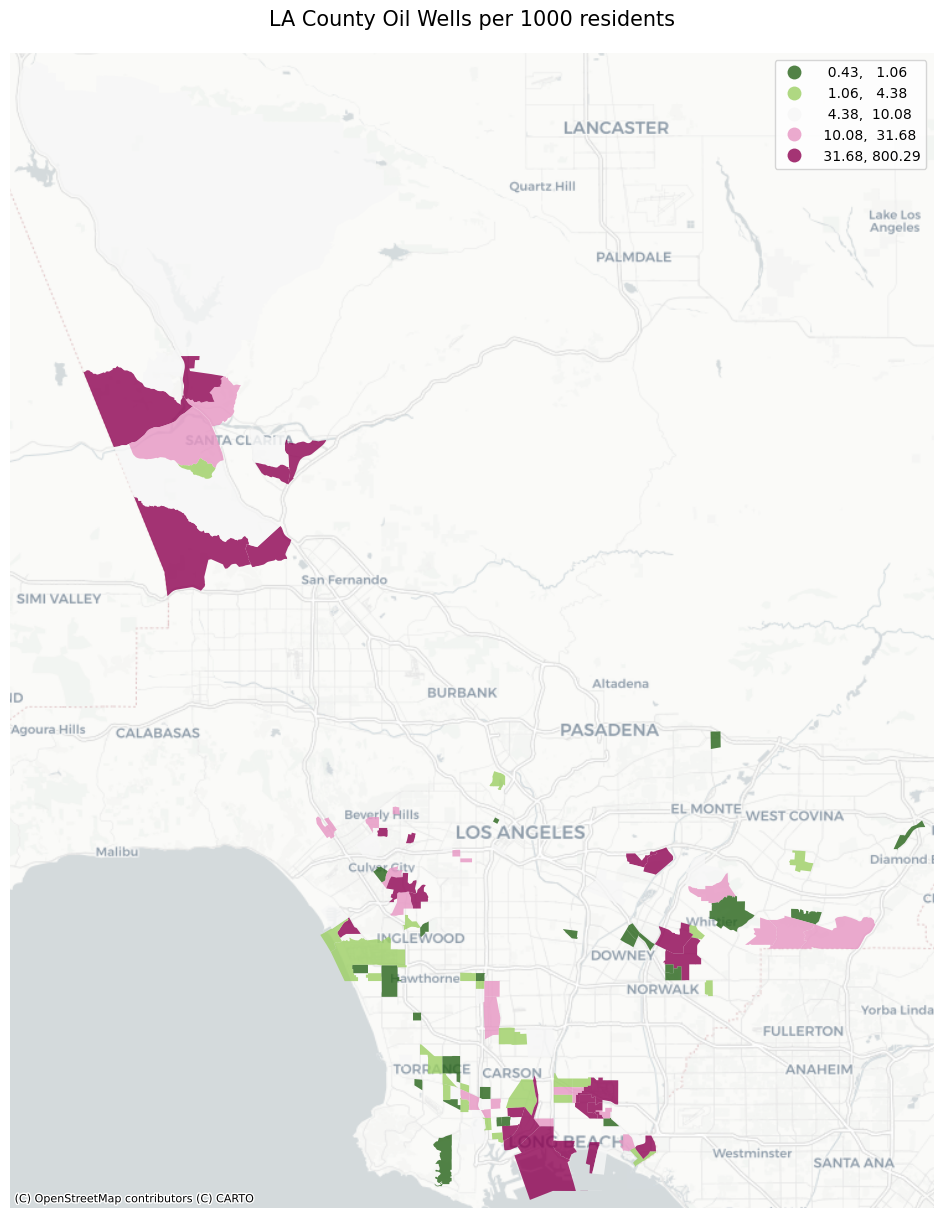

In [36]:
# Then plot within the bounds!
fig,ax = plt.subplots(figsize=(15,15))

bg_geo.plot(ax=ax,
        column='oilwells_per_1000', # this defines the field to "choropleth"
        legend=True,
        alpha=0.8,
        cmap='PiYG_r', # the "_r" reverses the color
        scheme='quantiles')

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx2 - 1000, maxx2 + 1000) # including margin around total bounds
ax.set_ylim(miny2 - 1000, maxy2 + 1000)

ax.axis('off')
ax.set_title('LA County Oil Wells per 1000 residents',fontsize=15,pad=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Global Spatial Autocorrelation
With the above plot, areas such as Santa Clarita, Culver City, and Long Beach stand out being in the upper quintile of oil wells count for every 1000 people. 
**Would applying a spatial lag yield even more insights on which communities host high concertrations of oil wells the most burden of oil wells?**

In [37]:
# assign spatial weight. We will use the 'closest neighborhood' spatial weight approach because of our neighborhood analysis
wq =  lps.weights.KNN.from_dataframe(bg_geo,k=8)

# Row-standardization
wq.transform = 'r'

/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [ ]:
With the spatial weights assignned, we could find the spatial lag value of oil wells for every 1000 people; this metric whichtakes into account the data values of "neighbors" as defined by the spatial weight 

In [38]:
bg_geo['oilwells_per_1000_lag'] = lps.weights.lag_spatial(wq, bg_geo['oilwells_per_1000'])

In [39]:
# verify that the column computed correctly
bg_geo.sample(10)[['Geo_FIPS','Total_Population','oilwell_count','oilwells_per_1000','oilwells_per_1000_lag']]

,Geo_FIPS,Total_Population,oilwell_count,oilwells_per_1000,oilwells_per_1000_lag
103,6.037920e+09,873,20,22.909507,26.558944
101,6.037920e+09,898,4,4.454343,25.596836
107,6.037920e+09,825,7,8.484848,42.511391
9,6.037224e+09,1692,13,7.683215,41.759434
89,6.037651e+09,981,1,1.019368,2.941051
54,6.037544e+09,1750,1,0.571429,14.204059
28,6.037295e+09,1437,194,135.003479,25.389269
33,6.037409e+09,1682,25,14.863258,8.626388
49,6.037541e+09,1203,34,28.262677,3.370858
42,6.037504e+09,661,1,1.512859,30.590855


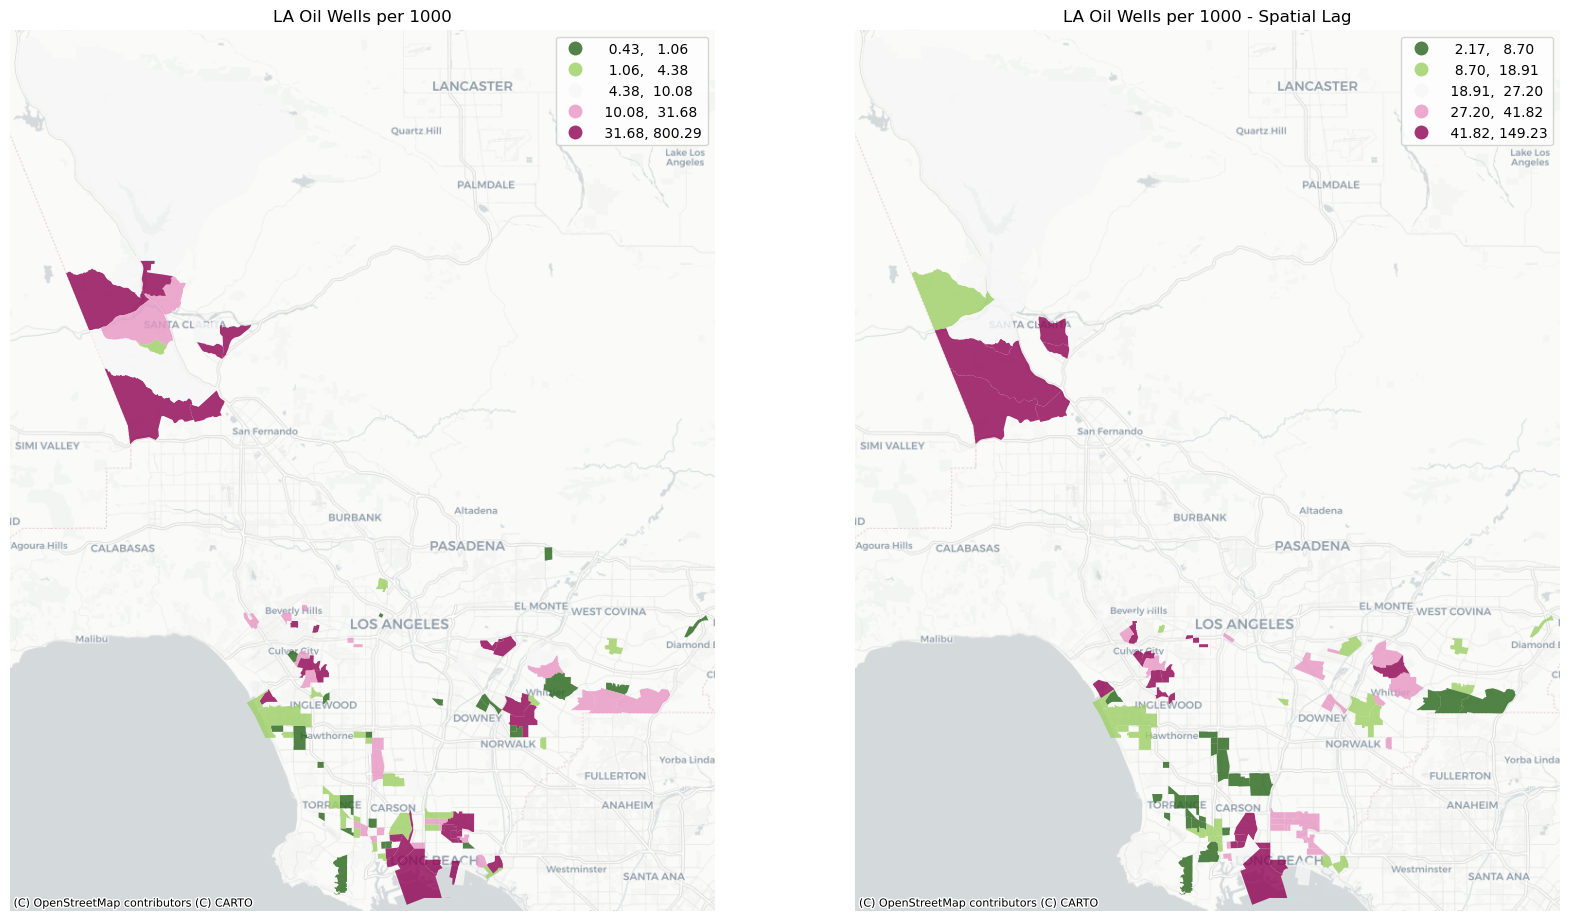

In [40]:
# let's see how they two compare graphically. First, we create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)
#1
bg_geo.plot(ax=ax[0],# to place this graphic on the left
        column='oilwells_per_1000', # define variable
        legend=True,
        alpha=0.8,
        cmap='PiYG_r', # reverses the color hierarchy
        scheme='quantiles',
        k=5,
        edgecolor='white',
        linewidth=0,
           )
# use the bounding box coordinates to set the x and y limits
ax[0].set_xlim(minx2 - 1000, maxx2 + 1000) # including margin around total bounds
ax[0].set_ylim(miny2 - 1000, maxy2 + 1000)

ax[0].axis("off")
ax[0].set_title("LA Oil Wells per 1000")
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron)

#2
bg_geo.plot(ax=ax[1],# to place this graphic on the left
        column='oilwells_per_1000_lag', 
        legend=True,
        alpha=0.8,
        cmap='PiYG_r', 
        scheme='quantiles',
        k=5,
        edgecolor='white',
        linewidth=0,
           )
# use the same bounding box as the LHS plot
ax[1].set_xlim(minx2 - 1000, maxx2 + 1000) # including margin around total bounds
ax[1].set_ylim(miny2 - 1000, maxy2 + 1000)

ax[1].axis("off")
ax[1].set_title("LA Oil Wells per 1000 - Spatial Lag")
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron)

plt.show()

In [ ]:
The oil wells spatial lag map displays geographies weighted against the values of its neighbors. While the same areas such Santa Clarita, Culver City, Inglewood, and Long Beach emerge in the top quintile of both plots, we begin to see that the clusters are much clearer on the spatial lag plot; there is higher concertration of oil wells in the Southern region of Santa Clarita than in the North, and similarly, top quintile concertration exists closer to and within Inglewood, and North from Culver City and Beverly Hills. The spatial lag plot also deprioritizes less inhabited areas such as North of Carson and North of Fullerton which feature in the 2nd quintile on the oil wells per 1000 metric (LHS) and fall in the lowest quintile in the spatial lag version of the metric (RHS).

In [ ]:
plt.savefig('spatial_lag_sidebyside.png')

In [ ]:
plt.savefig('2spatial_lag_sidebyside.jpeg')

In [ ]:
While we now know clusters, we want to explore the relationship between the oilwells_per_1000 variable and its spatial lag. To do so. we leverage the Moran tool which shows the moran value - the slope between the two variables; in terms of spatial mapping, the positive/negative and 0-1 scale score shows the extent to which proximate location's values on a variable differ

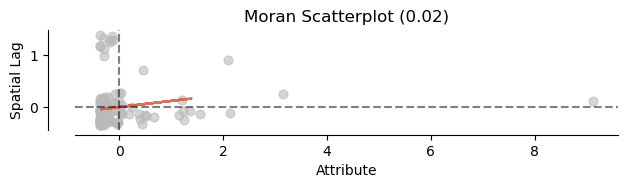

In [61]:
# Calculate moran score and plot graphic 
y = bg_geo.oilwells_per_1000
fig, ax = moran_scatterplot(Moran(y, wq), aspect_equal=True)
plt.show()

In [ ]:
The moran I score is close to a positive 0 in a -1 to 1 range which implies no autocorrelation/ perfect randomness. However, unlike other coefficients, the Moran value is an inferential statistic and one has to run the statistical significance before interpreting the value. As such, we run a p-value test on the null hypothesis that the test of the data is randomll

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


0.146

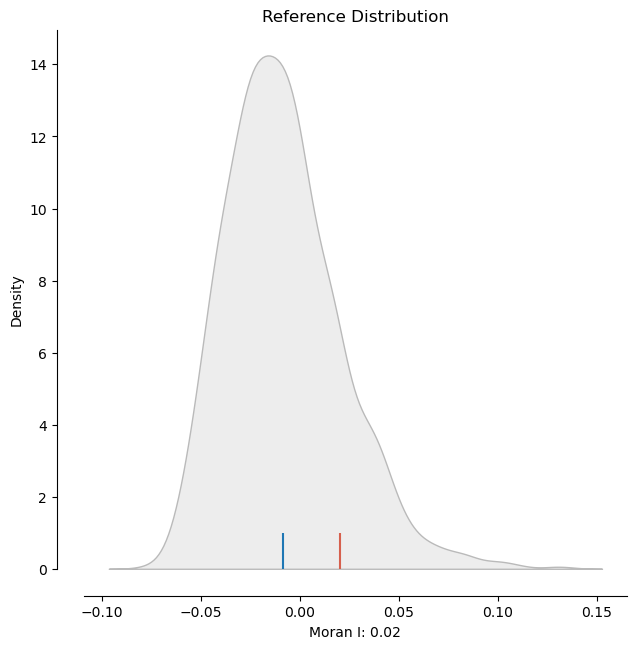

In [43]:
# plot the moran simulation and resulting p-value
moran = Moran(y, wq)
plot_moran_simulation(moran,aspect_equal=False)
moran.p_sim

In [ ]:
With a high p-value of 0.146 (p < 0.01 at 99% confidence level), we fail to reject the null hypothesis that the map is random. And so although we observe clusters, the moran value of 0.02 and high enough p-value support no global autocorrelation 

## Local Spatial Autocorrelation 
The above excercise sought to explore global autocorrelation, we want to investigate further where the clusters are although a picture on clusters has begun to emerge from prior plotting.
** Where are the clusters of high oil well concertrations?**

To do so, we leverage LISA which classifes different blocks into areas with highest and lowest oil well concertrations per residents developing four overall groups: 
HH: high oil well concertration geographies near other high concertration  neighbors
LL: low oil well concertration geographies near other low concertration neighbors
LH (donuts): llow oil well concertration surrounded by high concertration neighbors
HL (diamonds): high oil well concertration geographies surrounded by low concertration neighbors

In [44]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

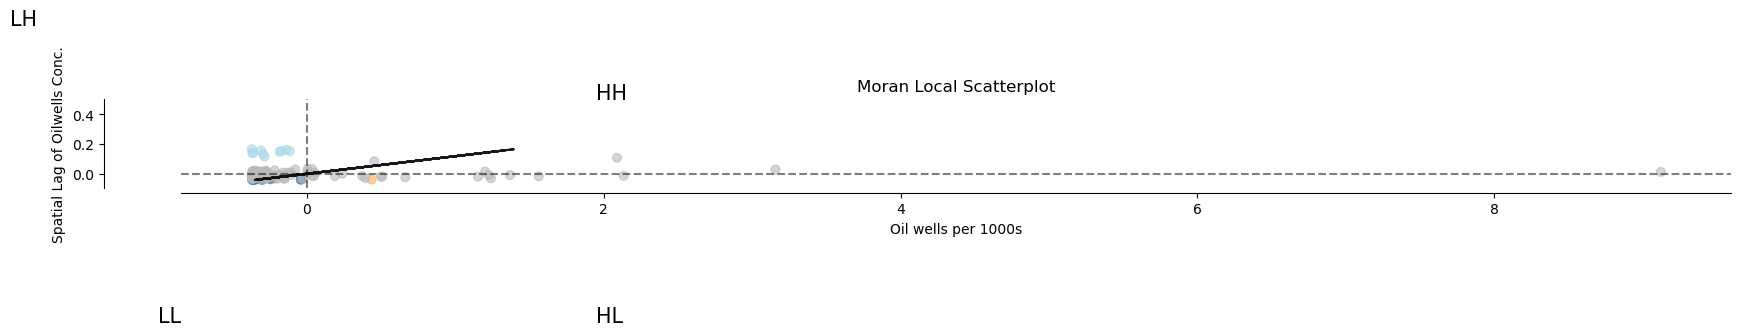

In [63]:
# Make a static plot of the clusters
fig,ax = plt.subplots(figsize=(20,15),)

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Oil wells per 1000s")
ax.set_ylabel('Spatial Lag of Oilwells Conc.')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=15)
plt.text(1.95, -1, "HL", fontsize=15)
plt.text(-2, 1, "LH", fontsize=15)
plt.text(-1, -1, "LL", fontsize=15)
plt.ylim(-0.1, 0.5) # added to make the plot more legible
plt.show()


In [ ]:
We see a clustering around the no spatial lag market. We are interested in the right hand side clusters and see a number of areas in the lower right/ HL (diamonds) quandrant; can we identify them visually? 
=

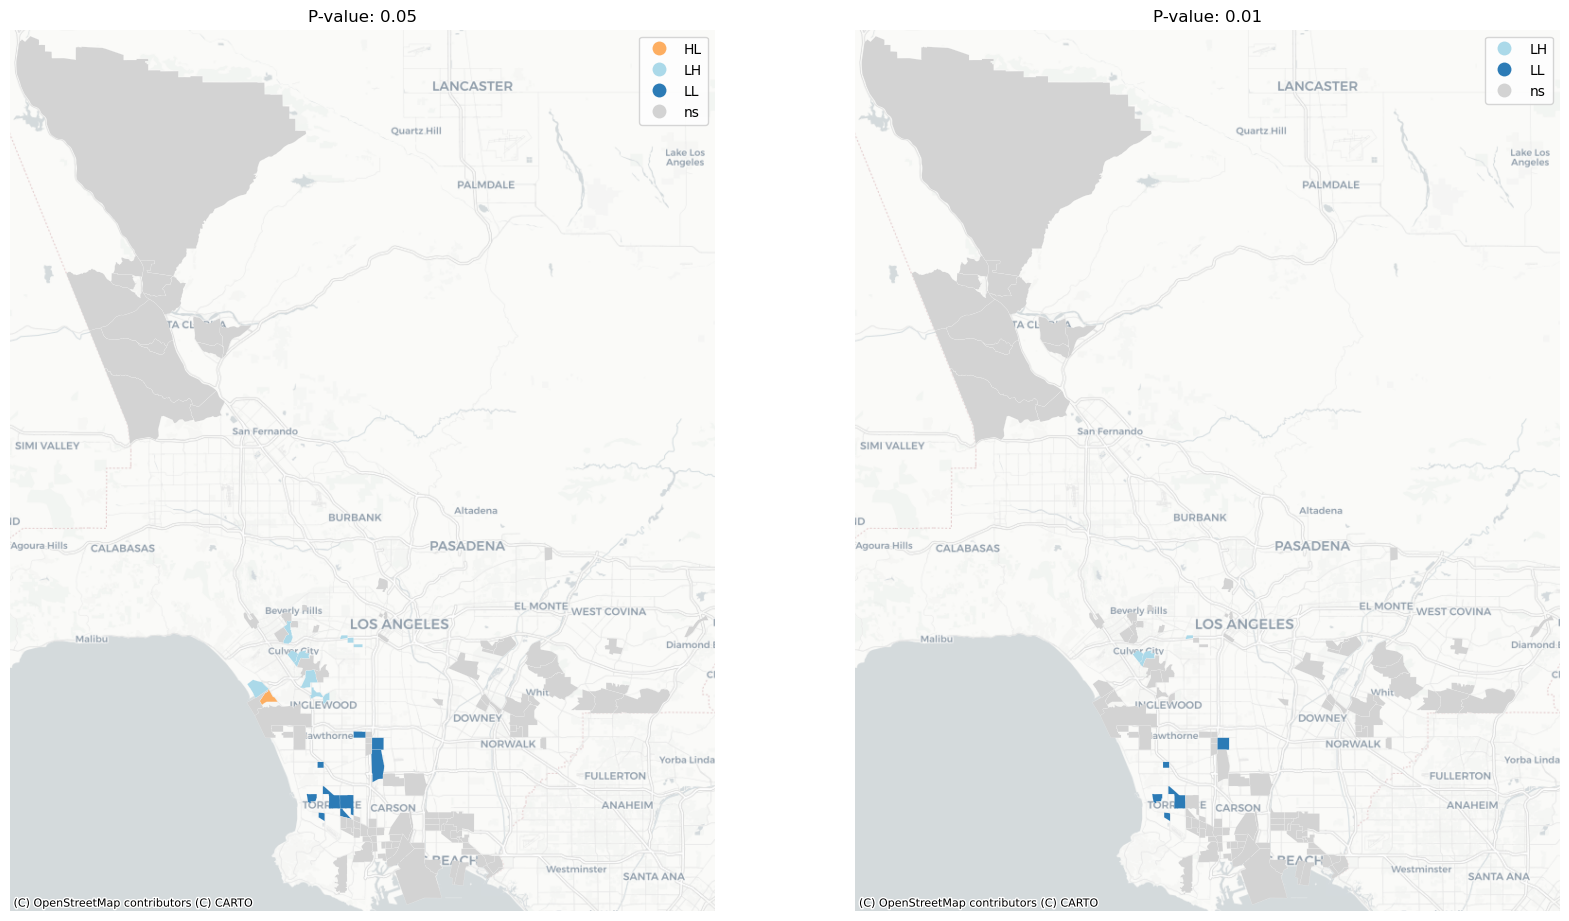

In [59]:
# Show oilwells_per_1000 clusters categorized in the four groups (HH, HL, LL, LH) and repeat the side-by-side subplots code for diff p-values 

# create the 1x2 subplots
fig, ax = plt.subplots(1, 2,figsize=(20, 12))

# spatial lag plot using lisa, p=0.05
lisa_cluster(lisa, bg_geo, p=0.05, ax=ax[0])

# axis
ax[0].set_xlim(minx2 - 1000, maxx2 + 1000) # including bg_geo bound margins
ax[0].set_ylim(miny2 - 1000, maxy2 + 1000)
ax[0].axis("off")
ax[0].set_title("P-value: 0.05")
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron)

# spatial lag plot using lisa, p = 0.1 zooming in on city of Los Angeles where we see most clustering information
lisa_cluster(lisa, bg_geo, p=0.01, ax=ax[1])
# axis
ax[1].set_xlim(minx2 - 1000, maxx2 + 1000) # including bg_geo bound margins
ax[1].set_ylim(miny2 - 1000, maxy2 + 1000)
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron)

plt.show()

Although large areas remain statistically non-significant (shown in grey), we can see light-blue LH patches around the Culver City, and Inglewood areas. 